# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

In [62]:
#set up block
import numpy as np
import pandas as pd
import seaborn as sns

**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

 1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.

False
         Make  Make_Year   Color  Body_Type  Mileage_Run No_of_Owners  \
0  Volkswagen       2017  silver      sedan        44611          1st   
1     Hyundai       2016     red  crossover        20305          1st   
2       Honda       2019   white        suv        29540          2nd   
3     Renault       2017  bronze  hatchback        35680          1st   
4     Hyundai       2017  orange  hatchback        25126          1st   

   Seating_Capacity Fuel_Type Transmission Transmission_Type   Price  age  
0                 5    diesel      7-Speed         Automatic  657000    5  
1                 5    petrol      5-Speed            Manual  682000    6  
2                 5    petrol      5-Speed            Manual  793000    3  
3                 5    petrol      5-Speed            Manual  414000    5  
4                 5    petrol      5-Speed            Manual  515000    5   



<Axes: >

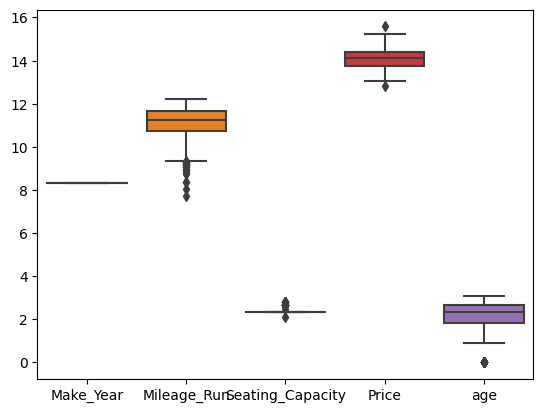

In [63]:
cars = pd.read_csv('/content/cars_hw.csv')

original_cars = cars

#check for NANs
print(cars.isnull().sum().any())

#remove 'Unnamed'
cars = cars.drop(cars.columns[0], axis = 1)

cars['age'] = max(cars['Make_Year'])-cars['Make_Year'] # Convert year to age

print(cars.head(), "\n")


#get rid of outliers
#view before - Price is the problem
#sns.boxplot(cars)

#windsorize function from model_evaluation class notes
def windsorize(x):
    # Compute IQR and 1st,3rd quantiles
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Windsorize x:
    x_windsor = x
    x_windsor[ x < lower_whisker ] = lower_whisker
    x_windsor[ x > upper_whisker ] = upper_whisker
    return(x_windsor)

#windsorize(cars['Price'])
#windsorize(cars['Mileage_Run'])

#decided that getting rid of outliers was not good


#scale price var
#try with both log and arcsinh

#cars['Price_log'] = np.log(cars['Price'])
#cars.loc[cars['Price_log']>0,'Price_log'].hist(bins=20,grid=False)

cars["Price"] = np.arcsinh(cars['Price'])
cars['Mileage_Run'] = np.arcsinh(cars['Mileage_Run'])
cars['age'] = np.arcsinh(cars['age'])
cars['Make_Year'] = np.arcsinh(cars['Make_Year'])
cars['Seating_Capacity'] = np.arcsinh(cars['Seating_Capacity'])
#cars['Price_arcsinh'].hist(bins=20,grid=False)

#cars["Price"] = cars['Price_arcsinh']

sns.boxplot(cars)

2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?

In general each car brand has a target price range that most of their models fall into. Some brands like Honda have a more equally distributed price range, where Kia, for example, had prices concentrated in a smaller range. The brands with the most consistently expensive cars are MG Motors, Kia, and Volkswagen. Datsun is noticeable, that is due to there only being three models under that brand that are close in price.

count    976.000000
mean      14.104181
std        0.450276
min       12.837344
25%       13.765795
50%       14.102942
75%       14.384228
max       15.587407
Name: Price, dtype: float64


<Axes: ylabel='Density'>

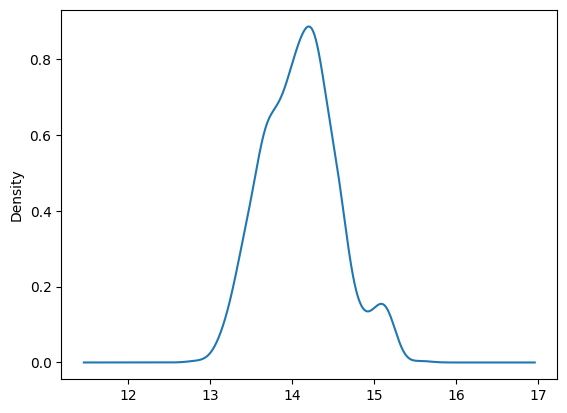

In [64]:
#Price Variable
print(cars["Price"].describe())
cars["Price"].plot.density()

<Axes: ylabel='Density'>

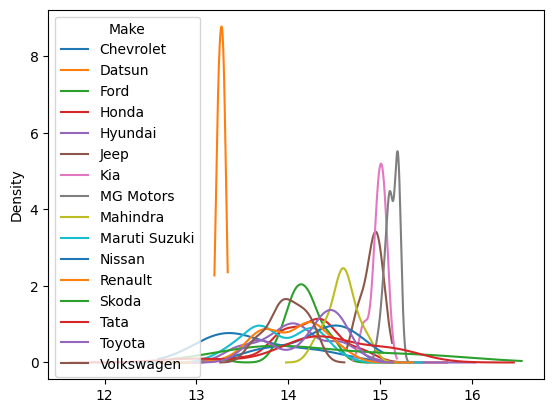

In [65]:

group_by = 'Make'
var = 'Price'
df_wide = cars.pivot(columns=group_by,values=var)
df_wide.plot.density()


  3. Split the data into an 80% training set and a 20% testing set.

In [66]:
import matplotlib.pyplot as plt

y = cars['Price'] # Create target variable vector
X = cars.loc[:,['Make','Make_Year',	'Color', 'Body_Type', 'Mileage_Run',	'No_of_Owners', 'Seating_Capacity',	'Fuel_Type',	'Transmission',	'Transmission_Type', 'age']] # Create feature matrix
#X = X.apply(maxmin) # Normalize X

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

print(len(y_train))
print(X_train.shape)

780
(780, 11)


4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?

Within the model we are looking for a R^2 closer to 1, and a RSME closer to 0. Between numerical and categorical variables, the set of categoricals predict the model better. However, the best model is produced by including all variables.

In [67]:
from sklearn.linear_model import LinearRegression # Import linear regression model

#numeric model
X_test['(Intercept)'] = 1
X_test_num = X_test.loc[:,['(Intercept)', 'age', 'Mileage_Run', 'Seating_Capacity']]
N_test = len(y_test)

X_train['(Intercept)'] = 1
X_train_num = X_train.loc[:,['(Intercept)', 'age', 'Mileage_Run', 'Seating_Capacity']]

reg = LinearRegression().fit(X_train_num, y_train)
r2_num = reg.score(X_test_num, y_test)
y_hat = reg.predict(X_test_num)
residuals = y_test - y_hat
SSE_num = np.sum(np.square(y_hat - y_test))
RMSE_num = (SSE_num/N_test)**(1/2)
print(r2_num, '\n')
print(RMSE_num, '\n')

0.36339663522858967 

0.3544071924040952 



In [68]:
from sklearn.linear_model import LinearRegression # Import linear regression model

#cat model
X_test_cat = X_test.loc[:,['Make','Color', 'Body_Type',	'No_of_Owners',	'Fuel_Type',	'Transmission',	'Transmission_Type']]
X_train_cat = X_train.loc[:,['Make','Color', 'Body_Type',	'No_of_Owners',	'Fuel_Type',	'Transmission',	'Transmission_Type']]

#has to go through cols
df0 = pd.get_dummies(X_test_cat.iloc[:, 0])
df1 = pd.get_dummies(X_test_cat.iloc[:, 1])
df2 = pd.get_dummies(X_test_cat.iloc[:, 2])
df3 = pd.get_dummies(X_test_cat.iloc[:, 3])
df4 = pd.get_dummies(X_test_cat.iloc[:, 4])
df5 = pd.get_dummies(X_test_cat.iloc[:, 5])
df6 = pd.get_dummies(X_test_cat.iloc[:, 6])

joined_test = pd.concat([df0.reset_index(drop=True), df1.reset_index(drop=True), df2.reset_index(drop=True), df3.reset_index(drop=True), df4.reset_index(drop=True), df5.reset_index(drop=True), df6.reset_index(drop=True)], axis = 1)
#add cols to test
joined_test['Chevrolet'] = 0
col = joined_test.pop('Chevrolet')
joined_test.insert(0, 'Chevrolet', col)

joined_test['Kia'] = 0
col = joined_test.pop('Kia')
joined_test.insert(6, 'Kia', col)

joined_test['Nissan'] = 0
col = joined_test.pop('Nissan')
joined_test.insert(10, 'Nissan', col)

joined_test['Skoda'] = 0
col = joined_test.pop('Skoda')
joined_test.insert(12, 'Skoda', col)

joined_test['petrol+cng'] = 0
col = joined_test.pop('petrol+cng')
joined_test.insert(41, 'petrol+cng', col)

joined_test['CVT'] = 0
col = joined_test.pop('CVT')
joined_test.insert(46, 'CVT', col)


#has to go through cols
df0 = pd.get_dummies(X_train_cat.iloc[:, 0])
df1 = pd.get_dummies(X_train_cat.iloc[:, 1])
df2 = pd.get_dummies(X_train_cat.iloc[:, 2])
df3 = pd.get_dummies(X_train_cat.iloc[:, 3])
df4 = pd.get_dummies(X_train_cat.iloc[:, 4])
df5 = pd.get_dummies(X_train_cat.iloc[:, 5])
df6 = pd.get_dummies(X_train_cat.iloc[:, 6])

joined_train = pd.concat([df0.reset_index(drop=True), df1.reset_index(drop=True), df2.reset_index(drop=True), df3.reset_index(drop=True), df4.reset_index(drop=True), df5.reset_index(drop=True), df6.reset_index(drop=True)], axis = 1)

print(joined_test.columns)
print(joined_train.columns)

reg = LinearRegression().fit(joined_train, y_train)
r2_cat = reg.score(joined_test, y_test)
y_hat = reg.predict(joined_test)
residuals = y_test - y_hat
SSE_cat = np.sum(np.square(y_hat - y_test))
RMSE_cat = (SSE_cat/N_test)**(1/2)
print(r2_cat, '\n')
print(RMSE_cat, '\n')

Index(['Chevrolet', 'Datsun', 'Ford', 'Honda', 'Hyundai', 'Jeep', 'Kia',
       'MG Motors', 'Mahindra', 'Maruti Suzuki', 'Nissan', 'Renault', 'Skoda',
       'Tata', 'Toyota', 'Volkswagen', 'beige', 'black', 'blue', 'bronze',
       'brown', 'golden', 'green', 'grey', 'maroon', 'orange', 'purple', 'red',
       'silver', 'white', 'yellow', 'crossover', 'hatchback', 'muv', 'sedan',
       'suv', '1st', '2nd', '3rd', 'diesel', 'petrol', 'petrol+cng', '4-Speed',
       '5-Speed', '6-Speed', '7-Speed', 'CVT', 'Automatic', 'Manual'],
      dtype='object')
Index(['Chevrolet', 'Datsun', 'Ford', 'Honda', 'Hyundai', 'Jeep', 'Kia',
       'MG Motors', 'Mahindra', 'Maruti Suzuki', 'Nissan', 'Renault', 'Skoda',
       'Tata', 'Toyota', 'Volkswagen', 'beige', 'black', 'blue', 'bronze',
       'brown', 'golden', 'green', 'grey', 'maroon', 'orange', 'purple', 'red',
       'silver', 'white', 'yellow', 'crossover', 'hatchback', 'muv', 'sedan',
       'suv', '1st', '2nd', '3rd', 'diesel', 'petrol', 'p

In [69]:
#all regressors

X_test_all = pd.concat([X_test_num.reset_index(drop=True), joined_test.reset_index(drop=True)], axis = 1)
X_train_all = pd.concat([X_train_num.reset_index(drop=True), joined_train.reset_index(drop=True)], axis = 1)

X_test_all.head()

reg = LinearRegression().fit(X_train_all, y_train)
r2_all = reg.score(X_test_all, y_test)
y_hat = reg.predict(X_test_all)
residuals = y_test - y_hat
SSE_all = np.sum(np.square(y_hat - y_test))
RMSE_all = (SSE_all/N_test)**(1/2)
print(r2_all, '\n')
print(RMSE_all, '\n')

0.7959787279114323 

0.20063458021818203 



In [70]:
#CREATING TABLE
#Source: https://stackoverflow.com/questions/64506283/create-a-pandas-table
table = {
    'Test': ["Numerical", "Categorical", "All"],
    'R^2': [r2_num, r2_cat, r2_all],
    'RMSE': [RMSE_num, RMSE_cat, RMSE_all],
    }

df = pd.DataFrame(table)

df

,Test,R^2,RMSE
0,Numerical,0.363397,0.354407
1,Categorical,0.686855,0.248566
2,All,0.795979,0.200635


5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?

As the degree increased R2 should be increasing and RMSE decreasing until the model becomes overfit, as was mostly seen. In the case of this model a degree of 3 was overfit, and by 5 it was so majorly overfit that the R2 became negative. Compared to the previous part the expanded model with a degree of 2 performed better.

In [71]:
from sklearn.preprocessing import PolynomialFeatures

expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_test_num) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
#zdf.head()

expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_train_num) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf2 = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

#recombine with cats
X_test_all_2 = pd.concat([zdf.reset_index(drop=True), joined_test.reset_index(drop=True)], axis = 1)
X_train_all_2 = pd.concat([zdf2.reset_index(drop=True), joined_train.reset_index(drop=True)], axis = 1)

X_test_all_2.head()

reg_2 = LinearRegression().fit(X_train_all_2, y_train)
r2_2 = reg_2.score(X_test_all_2, y_test)
y_hat = reg_2.predict(X_test_all_2)
residuals = y_test - y_hat
SSE_2 = np.sum(np.square(y_hat - y_test))
RMSE_2 = (SSE_2/N_test)**(1/2)
print("R2 and RMSE for degree of 2", '\n')
print(r2_2, '\n')
print(RMSE_2, '\n')


expander = PolynomialFeatures(degree=3,include_bias=False) # Create the expander
Z = expander.fit_transform(X_test_num) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
#zdf.head()
expander = PolynomialFeatures(degree=3,include_bias=False) # Create the expander
Z = expander.fit_transform(X_train_num) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf2 = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

#recombine with cats
X_test_all_3 = pd.concat([zdf.reset_index(drop=True), joined_test.reset_index(drop=True)], axis = 1)
X_train_all_3 = pd.concat([zdf2.reset_index(drop=True), joined_train.reset_index(drop=True)], axis = 1)

X_test_all_3.head()

reg = LinearRegression().fit(X_train_all_3, y_train)
r2_3 = reg.score(X_test_all_3, y_test)
y_hat = reg.predict(X_test_all_3)
residuals = y_test - y_hat
SSE_3 = np.sum(np.square(y_hat - y_test))
RMSE_3 = (SSE_3/N_test)**(1/2)
print("R2 and RMSE for degree of 5", '\n')
print(r2_3, '\n')
print(RMSE_3, '\n')


expander = PolynomialFeatures(degree=5,include_bias=False) # Create the expander
Z = expander.fit_transform(X_test_num) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
#zdf.head()
expander = PolynomialFeatures(degree=5,include_bias=False) # Create the expander
Z = expander.fit_transform(X_train_num) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
zdf2 = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

#recombine with cats
X_test_all_5 = pd.concat([zdf.reset_index(drop=True), joined_test.reset_index(drop=True)], axis = 1)
X_train_all_5 = pd.concat([zdf2.reset_index(drop=True), joined_train.reset_index(drop=True)], axis = 1)

X_test_all_5.head()

reg = LinearRegression().fit(X_train_all_5, y_train)
r2_5 = reg.score(X_test_all_5, y_test)
y_hat = reg.predict(X_test_all_5)
residuals = y_test - y_hat
SSE_5 = np.sum(np.square(y_hat - y_test))
RMSE_5 = (SSE_5/N_test)**(1/2)
print("R2 and RMSE for degree of 10", '\n')
print(r2_5, '\n')
print(RMSE_5, '\n')


R2 and RMSE for degree of 2 

0.836261191072879 

0.1797396433205942 

R2 and RMSE for degree of 5 

0.7865791760607441 

0.20520430053470776 

R2 and RMSE for degree of 10 

-10.63841153853112 

1.515356851937385 



  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

The model chosen as the best so far uses all the regressors and expands the numerical variables by a degree of 10. The predicted and test values form a clear diagonal line, and the residuals have a rough bell shape.

Text(0, 0.5, 'Test Values')

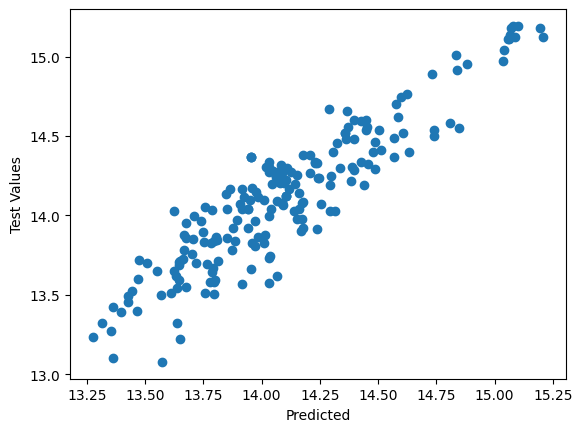

In [72]:
#best model so far was with degree of 10
y_hat_2 = reg_2.predict(X_test_all_2)
plt.scatter(y_hat_2, y_test)
plt.xlabel("Predicted")
plt.ylabel("Test Values")

<Axes: ylabel='Density'>

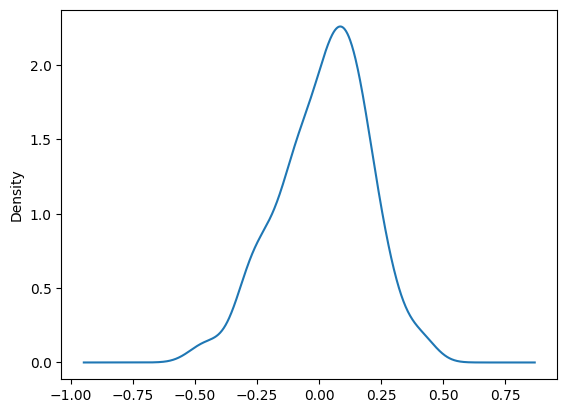

In [73]:
residuals_2 = y_test - y_hat_2
residuals_2.plot.kde()

7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?

The best tree that was found had a depth of 10, after that point the model became overfit and the values of R2 and RMSE plateaued.

In [74]:
from sklearn import tree # Import the tree classifier
#turn X_train_cat

cart = tree.DecisionTreeRegressor(max_depth=3) # Create a classifier object
cart = cart.fit(X_train_all, y_train) # Fit the classifier

r2 = cart.score(X_test_all, y_test)
y_hat = cart.predict(X_test_all)
residuals = y_test - y_hat
SSE = np.sum(np.square(y_hat - y_test))
RMSE = (SSE/N_test)**(1/2)
print("R2 and RMSE for depth of 3")
print(r2, '\n')
print(RMSE, '\n')

cart = tree.DecisionTreeRegressor(max_depth=6) # Create a classifier object
cart = cart.fit(X_train_all, y_train) # Fit the classifier

r2 = cart.score(X_test_all, y_test)
y_hat = cart.predict(X_test_all)
residuals = y_test - y_hat
SSE = np.sum(np.square(y_hat - y_test))
RMSE = (SSE/N_test)**(1/2)
print("R2 and RMSE for depth of 6")
print(r2, '\n')
print(RMSE, '\n')


cart_best = tree.DecisionTreeRegressor(max_depth=10) # Create a classifier object
cart_best = cart.fit(X_train_all, y_train) # Fit the classifier

r2_best = cart_best.score(X_test_all, y_test)
y_hat_best = cart_best.predict(X_test_all)
residuals = y_test - y_hat
SSE = np.sum(np.square(y_hat - y_test))
RMSE_best = (SSE/N_test)**(1/2)
print("R2 and RMSE for depth of 10")
print(r2_best, '\n')
print(RMSE_best, '\n')

cart = tree.DecisionTreeRegressor(max_depth=20) # Create a classifier object
cart = cart.fit(X_train_all, y_train) # Fit the classifier

r2 = cart.score(X_test_all, y_test)
y_hat = cart.predict(X_test_all)
residuals = y_test - y_hat
SSE = np.sum(np.square(y_hat - y_test))
RMSE = (SSE/N_test)**(1/2)
print("R2 and RMSE for depth of 20")
print(r2, '\n')
print(RMSE, '\n')
# Visualize results:
#tree.plot_tree(cart,filled=True)

R2 and RMSE for depth of 3
0.6499073123743841 

0.26282070864908874 

R2 and RMSE for depth of 6
0.7344566041324434 

0.22889474095392587 

R2 and RMSE for depth of 10
0.7345623200829698 

0.22889474095392587 

R2 and RMSE for depth of 20
0.7321969315439161 

0.2298665811231318 



  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?

When the test values are plotted against the results they form a line along the diagonal. When a kernel density plot is formed a bell curve can generally be seen.

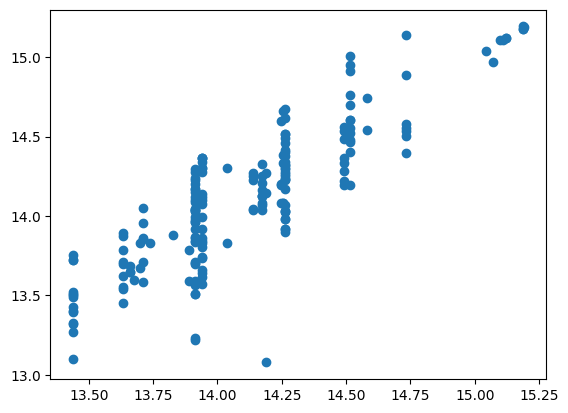

In [75]:
y_hat_best = cart_best.predict(X_test_all)
plt.scatter(y_hat_best, y_test)

<Axes: ylabel='Density'>

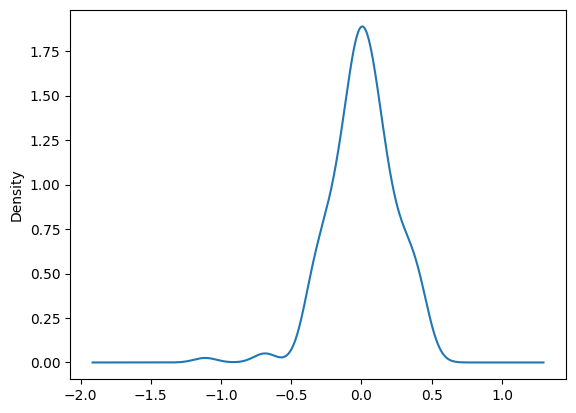

In [76]:
residuals_best = y_test - y_hat_best
residuals_best.plot.kde()

 12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

Constructed below is a table comparing the best versions of the linear and tree models. As is shown the linear model fit the data better, and formed better predictions on the test data set.

In [77]:
#form table to compare
table = {
    'Model': ["Linear", "Tree"],
    'R^2': [r2_2, r2_best],
    'RMSE': [RMSE_2, RMSE_best],
    }

df = pd.DataFrame(table)

df

,Model,R^2,RMSE
0,Linear,0.836261,0.179740
1,Tree,0.734562,0.228895


**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.

In [80]:
wages = pd.read_csv('/content/wages_hw.csv')

#remove 'Unnamed'
wages = wages.drop(wages.columns[0], axis = 1)
wages = wages[wages['Sector'] != '-1']
#windsorize function from model_evaluation class notes
def windsorize(x):
    # Compute IQR and 1st,3rd quantiles
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Windsorize x:
    x_windsor = x
    x_windsor[ x < lower_whisker ] = lower_whisker
    x_windsor[ x > upper_whisker ] = upper_whisker
    return(x_windsor)

#windsorize(wages['Rating'])
windsorize(wages['avg_salary'])

#wages['Rating'] = np.log(wages['Rating'])
wages['avg_salary'] = np.log(wages['avg_salary'])

#sns.boxplot(wages)
import matplotlib.pyplot as plt

y = wages['avg_salary'] # Create target variable vector
X = wages.loc[:,['Rating', 'Size', 'Sector', 'job_state']] # Create feature matrix
#X = X.apply(maxmin) # Normalize X

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

<ipython-input-80-2bc2dd3d44d8>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x > upper_whisker ] = upper_whisker


 2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set?

The Setor variable does not seem to be able to predict the average salary. I believe this could be for one of a few reasons. Number one: human error, I could have made a mistake in my code that I can not find. Number two: the data is too broad: there are a decent number of categories but they are still a broad overview of all jobs. There could be many different jobs in each category with different salary ranges that make predicting off of the category not functional.

['Biotech & Pharmaceuticals' 'Construction, Repair & Maintenance'
 'Telecommunications' 'Manufacturing' 'Insurance' 'Health Care'
 'Information Technology' 'Education' 'Aerospace & Defense' 'Finance'
 'Business Services' 'Retail' 'Agriculture & Forestry'
 'Transportation & Logistics' 'Mining & Metals' 'Travel & Tourism'
 'Government' 'Non-Profit' 'Oil, Gas, Energy & Utilities']
-1.5442577699920898e+24 

520612015627.5873 



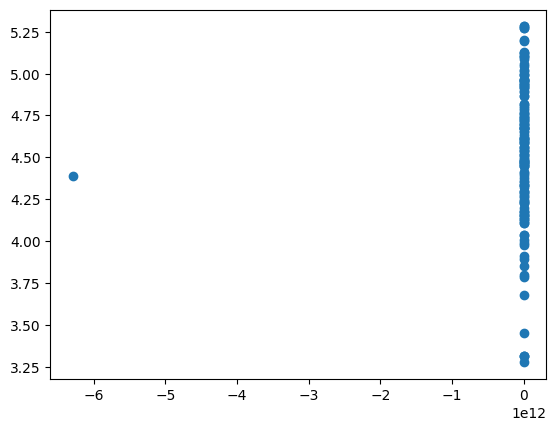

In [81]:
from sklearn.linear_model import LinearRegression # Import linear regression model

x_test_sector = X_test['Sector']
x_train_sector = X_train['Sector']
x_test_sector = pd.get_dummies(x_test_sector)
x_train_sector = pd.get_dummies(x_train_sector)

print(X_test['Sector'].unique())

x_test_sector['Accounting & Legal'] = 0
col = x_test_sector.pop('Accounting & Legal')
x_test_sector.insert(0, 'Accounting & Legal', col)

x_test_sector['Arts, Entertainment & Recreation'] = 0
col = x_test_sector.pop('Arts, Entertainment & Recreation')
x_test_sector.insert(3, 'Arts, Entertainment & Recreation', col)

x_test_sector['Consumer Services'] = 0
col = x_test_sector.pop('Consumer Services')
x_test_sector.insert(7, 'Consumer Services', col)

x_test_sector['Media'] = 0
col = x_test_sector.pop('Media')
x_test_sector.insert(15, 'Media', col)

x_test_sector['Real Estate'] = 0
col = x_test_sector.pop('Real Estate')
x_test_sector.insert(19, 'Real Estate', col)

x_train_sector['Agriculture & Forestry'] = 0
col = x_train_sector.pop('Agriculture & Forestry')
x_train_sector.insert(2, 'Agriculture & Forestry', col)

N_test = len(y_test)

reg = LinearRegression().fit(x_train_sector, y_train)
r2 = reg.score(x_test_sector, y_test)
y_hat = reg.predict(x_test_sector)
SSE = np.sum(np.square(y_hat - y_test))
RMSE = (SSE/N_test)**(1/2)
print(r2, '\n')
print(RMSE, '\n')

plt.scatter(y_hat, y_test)

 3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?

I once again got results that showed predictions for average salary could not be made with the variable. This could be human error again. It could also be the data. The rating could be too limited of a measure to prediect average salary since people could rates jobs based on any feature besides salary. I think the regression with the numerical version worked better since the data had a bit more values that are different.

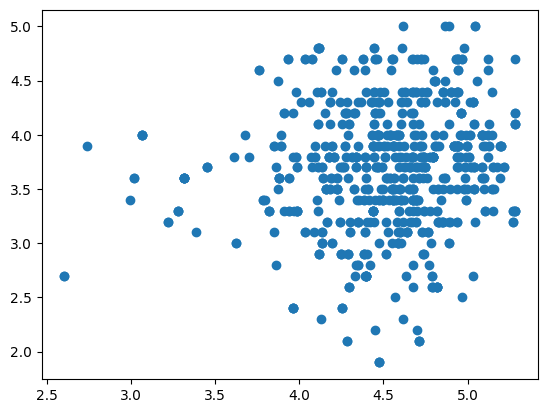

In [82]:
plt.scatter(wages['avg_salary'], wages['Rating'])

0.006868478908183873 

0.41750114688941664 



<ipython-input-83-42f60793e1d3>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  reg = LinearRegression().fit(x_train_rating[:, None], y_train)
<ipython-input-83-42f60793e1d3>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  r2 = reg.score(x_test_rating[:, None], y_test)
<ipython-input-83-42f60793e1d3>:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_hat = reg.predict(x_test_rating[:, None])


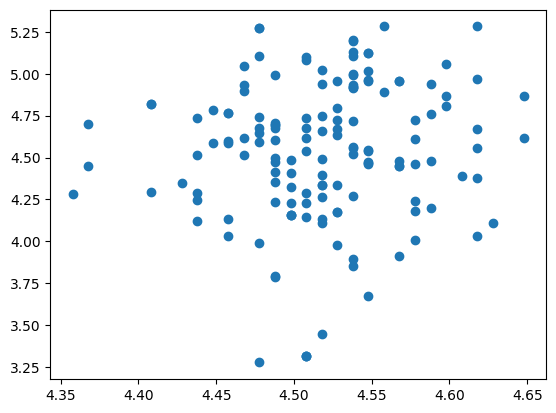

In [83]:
x_test_rating = X_test['Rating']
x_train_rating = X_train['Rating']

reg = LinearRegression().fit(x_train_rating[:, None], y_train)
r2 = reg.score(x_test_rating[:, None], y_test)
y_hat = reg.predict(x_test_rating[:, None])
SSE = np.sum(np.square(y_hat - y_test))
RMSE = (SSE/N_test)**(1/2)
print(r2, '\n')
print(RMSE, '\n')

plt.scatter(y_hat, y_test)

Float64Index([2.0, 3.0, 4.0, 5.0], dtype='float64')
Float64Index([2.0, 3.0, 4.0, 5.0], dtype='float64')
-0.02866521257529997 

0.42490448603175857 



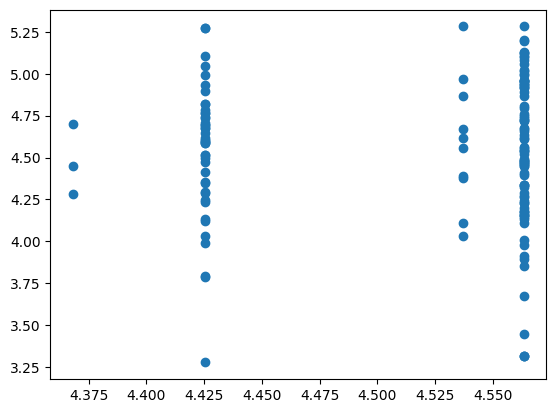

In [84]:
#round so can convert to one hot encoding
x_test_rating_cat = np.round_(x_test_rating, decimals = 0)
x_train_rating_cat = np.round_(x_train_rating, decimals = 0)

x_test_rating_cat = pd.get_dummies(x_test_rating_cat)
x_train_rating_cat = pd.get_dummies(x_train_rating_cat)

print(x_test_rating_cat.columns)
print(x_train_rating_cat.columns)

#run a regression of avg_salary on the categorical version
reg = LinearRegression().fit(x_train_rating_cat, y_train)
r2 = reg.score(x_test_rating_cat, y_test)
y_hat = reg.predict(x_test_rating_cat)
SSE = np.sum(np.square(y_hat - y_test))
RMSE = (SSE/N_test)**(1/2)
print(r2, '\n')
print(RMSE, '\n')

plt.scatter(y_hat, y_test)

  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?

I am not sure why the data is doing what it is doing. The results of this regression make sense sompared to the previous ones but I am unsure why none of the features are creating a good model. The R2 value indicates the model is a bad fit for the data.



-1.3148578129774946e+26 

4803896980506.303 



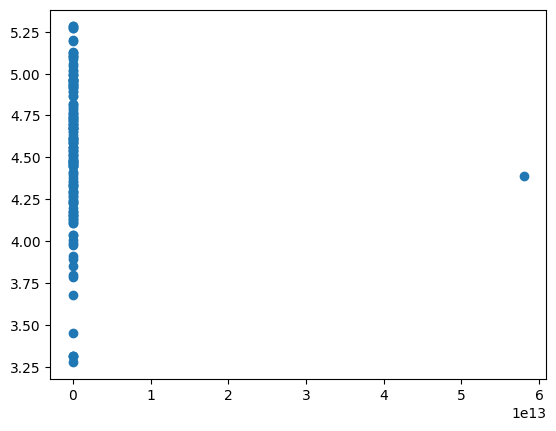

In [85]:
from sklearn.preprocessing import PolynomialFeatures

#use x_test_rating_cat and x_train_sector
x_test_both = pd.concat([x_test_rating_cat.reset_index(drop=True), x_test_sector.reset_index(drop=True)], axis = 1)
x_test_both.columns = x_test_both.columns.astype(str)
x_test_both = x_test_both.dropna()

expander = PolynomialFeatures(degree=2,include_bias=False)
Z = expander.fit_transform(x_test_both)
names = expander.get_feature_names_out()
zdf_test = pd.DataFrame(data=Z, columns = names)


x_train_both = pd.concat([x_train_rating_cat.reset_index(drop=True), x_train_sector.reset_index(drop=True)], axis = 1)
x_train_both.columns = x_train_both.columns.astype(str)
x_train_both = x_train_both.dropna()

expander = PolynomialFeatures(degree=2,include_bias=False)
Z = expander.fit_transform(x_train_both)
names = expander.get_feature_names_out()
zdf_train = pd.DataFrame(data=Z, columns = names)

#run a regression of avg_salary on the categorical version
reg = LinearRegression().fit(zdf_train, y_train)
r2 = reg.score(zdf_test, y_test)
y_hat = reg.predict(zdf_test)
SSE = np.sum(np.square(y_hat - y_test))
RMSE = (SSE/N_test)**(1/2)
print(r2, '\n')
print(RMSE, '\n')

plt.scatter(y_hat, y_test)

  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4?

-5.791918704303234e+24 

1008243703373.4164 



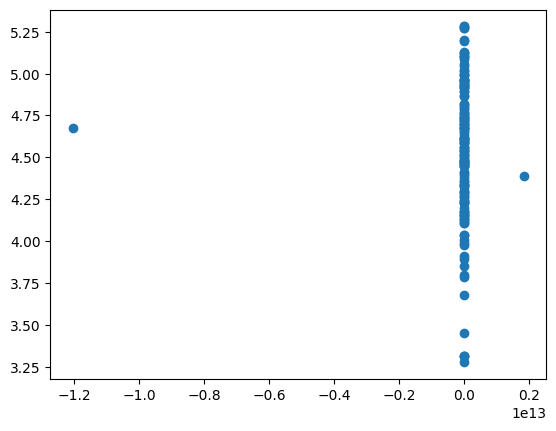

In [86]:
X_test_cat = X_test.loc[:,['Size', 'job_state']]
X_test_cat = pd.get_dummies(X_test_cat)

#X_test_cat['job_state_ Los Angeles'] = X_test_cat['job_state_ LA']
#X_test_cat = X_test_cat.rename(index={17: 'job_state_ LA'})

#print(X_test_cat.columns.get_loc('job_state_ LA'))

X_test_cat['job_state_ LA'] = 0
col = X_test_cat.pop('job_state_ Los Angeles')
col = X_test_cat.pop('job_state_ LA')
X_test_cat.insert(17, 'job_state_ LA', col)

X_test_cat['job_state_ CT'] = 0
col = X_test_cat.pop('job_state_ CT')
X_test_cat.insert(11, 'job_state_ CT', col)

X_test_cat['job_state_ DC'] = 0
col = X_test_cat.pop('job_state_ DC')
X_test_cat.insert(12, 'job_state_ DC', col)

X_test_cat['job_state_ ID'] = 0
col = X_test_cat.pop('job_state_ ID')
X_test_cat.insert(17, 'job_state_ ID', col)

X_test_cat['job_state_ KS'] = 0
col = X_test_cat.pop('job_state_ KS')
X_test_cat.insert(20, 'job_state_ KS', col)

X_test_cat['job_state_ KY'] = 0
col = X_test_cat.pop('job_state_ KY')
X_test_cat.insert(21, 'job_state_ KY', col)

X_test_cat['job_state_ NE'] = 0
col = X_test_cat.pop('job_state_ NE')
X_test_cat.insert(29, 'job_state_ NE', col)

X_test_cat['job_state_ OR'] = 0
col = X_test_cat.pop('job_state_ OR')
X_test_cat.insert(34, 'job_state_ OR', col)

X_test_cat['job_state_ RI'] = 0
col = X_test_cat.pop('job_state_ RI')
X_test_cat.insert(36, 'job_state_ RI', col)

X_test_cat['job_state_ SC'] = 0
col = X_test_cat.pop('job_state_ SC')
X_test_cat.insert(37, 'job_state_ SC', col)

X_test_cat['Size_Unknown'] = 0
col = X_test_cat.pop('Size_Unknown')
X_test_cat.insert(7, 'Size_Unknown', col)

x_test_all = pd.concat([x_test_rating_cat.reset_index(drop=True), x_test_sector.reset_index(drop=True), X_test_cat.reset_index(drop=True)], axis = 1)
x_test_all.columns = x_test_all.columns.astype(str)
x_test_all = x_test_all.dropna()

X_train_cat = X_train.loc[:,['Size', 'job_state']]
X_train_cat = pd.get_dummies(X_train_cat)

x_train_all = pd.concat([x_train_rating_cat.reset_index(drop=True), x_train_sector.reset_index(drop=True), X_train_cat.reset_index(drop=True)], axis = 1)
x_train_all.columns = x_train_all.columns.astype(str)
x_train_all = x_train_all.dropna()

reg = LinearRegression().fit(x_train_all, y_train)
r2 = reg.score(x_test_all, y_test)
y_hat = reg.predict(x_test_all)
SSE = np.sum(np.square(y_hat - y_test))
RMSE = (SSE/N_test)**(1/2)
print(r2, '\n')
print(RMSE, '\n')

plt.scatter(y_hat, y_test)


  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?


A desions tree seems to make predictions on the data better, and is overall a better model for the data. The version with the most information (with both Sector and and Rating) was able to create a model where the results can almost form a general line up with the test values


Sector - R2 and RMSE for depth of 20
0.20541624551546334 

0.37344283427638314 

Rating - R2 and RMSE for depth of 20
-0.005684236513830543 

0.42013137087520924 

Sector and Rating - R2 and RMSE for depth of 20
0.3400242568705264 

0.34034413937223046 



<ipython-input-87-5737bc0ab8e3>:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cart = cart.fit(x_train_rating[:, None], y_train) # Fit the classifier
<ipython-input-87-5737bc0ab8e3>:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  r2 = cart.score(x_test_rating[:, None], y_test)
<ipython-input-87-5737bc0ab8e3>:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_hat = cart.predict(x_test_rating[:, None])


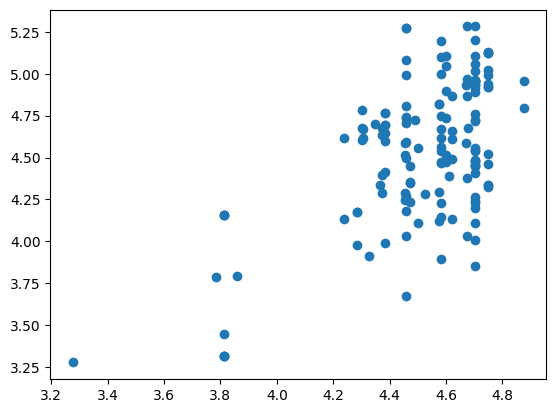

In [87]:
from sklearn import tree # Import the tree classifier

#tree based on Sector
cart = tree.DecisionTreeRegressor(max_depth=20) # Create a classifier object
cart = cart.fit(x_train_sector, y_train) # Fit the classifier

r2 = cart.score(x_test_sector, y_test)
y_hat = cart.predict(x_test_sector)
residuals = y_test - y_hat
SSE = np.sum(np.square(y_hat - y_test))
RMSE = (SSE/N_test)**(1/2)
print("Sector - R2 and RMSE for depth of 20")
print(r2, '\n')
print(RMSE, '\n')


#tree based on Rating
cart = tree.DecisionTreeRegressor(max_depth=20) # Create a classifier object
cart = cart.fit(x_train_rating[:, None], y_train) # Fit the classifier

r2 = cart.score(x_test_rating[:, None], y_test)
y_hat = cart.predict(x_test_rating[:, None])
residuals = y_test - y_hat
SSE = np.sum(np.square(y_hat - y_test))
RMSE = (SSE/N_test)**(1/2)
print("Rating - R2 and RMSE for depth of 20")
print(r2, '\n')
print(RMSE, '\n')

#tree with Sector and Rating
cart = tree.DecisionTreeRegressor(max_depth=20) # Create a classifier object
cart = cart.fit(x_train_both, y_train) # Fit the classifier

r2 = cart.score(x_test_both, y_test)
y_hat = cart.predict(x_test_both)
residuals = y_test - y_hat
SSE = np.sum(np.square(y_hat - y_test))
RMSE = (SSE/N_test)**(1/2)
print("Sector and Rating - R2 and RMSE for depth of 20")
print(r2, '\n')
print(RMSE, '\n')

plt.scatter(y_hat, y_test)

 7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?

Using all variables resulting in preductions that were not completely off based on the test set.

Sector and Rating - R2 and RMSE for depth of 20
0.5544652161062744 

0.2796372984181984 



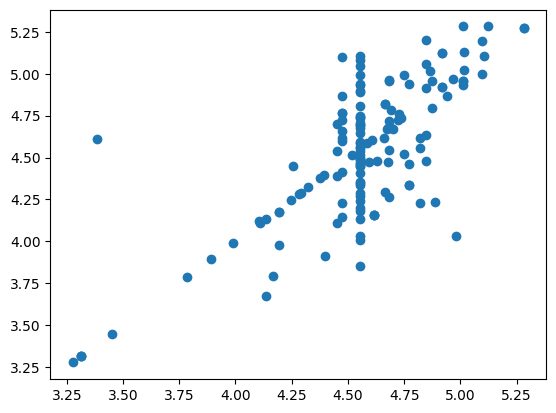

In [88]:
#for all variables
cart = tree.DecisionTreeRegressor(max_depth=20) # Create a classifier object
cart = cart.fit(x_train_all, y_train) # Fit the classifier

r2 = cart.score(x_test_all, y_test)
y_hat = cart.predict(x_test_all)
residuals = y_test - y_hat
SSE = np.sum(np.square(y_hat - y_test))
RMSE = (SSE/N_test)**(1/2)
print("Sector and Rating - R2 and RMSE for depth of 20")
print(r2, '\n')
print(RMSE, '\n')

plt.scatter(y_hat, y_test)


  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

My idea was to build a regression off of the industry title and the location. My logic for removing the rating was that people could have a good/bad expirence at the job based on many factors besides pay. For size it was that high and low paying jobs could be at any company size. The model ended up preforming about the same as when all variables are included.

Index(['2.0', '3.0', '4.0', '5.0', 'Accounting & Legal', 'Aerospace & Defense',
       'Agriculture & Forestry', 'Arts, Entertainment & Recreation',
       'Biotech & Pharmaceuticals', 'Business Services',
       'Construction, Repair & Maintenance', 'Consumer Services', 'Education',
       'Finance', 'Government', 'Health Care', 'Information Technology',
       'Insurance', 'Manufacturing', 'Media', 'Mining & Metals', 'Non-Profit',
       'Oil, Gas, Energy & Utilities', 'Real Estate', 'Retail',
       'Telecommunications', 'Transportation & Logistics', 'Travel & Tourism',
       'Size_1 to 50 employees', 'Size_10000+ employees',
       'Size_1001 to 5000 employees', 'Size_201 to 500 employees',
       'Size_5001 to 10000 employees', 'Size_501 to 1000 employees',
       'Size_51 to 200 employees', 'Size_Unknown', 'job_state_ AL',
       'job_state_ AZ', 'job_state_ CA', 'job_state_ CO', 'job_state_ CT',
       'job_state_ DC', 'job_state_ DE', 'job_state_ FL', 'job_state_ GA',
       '

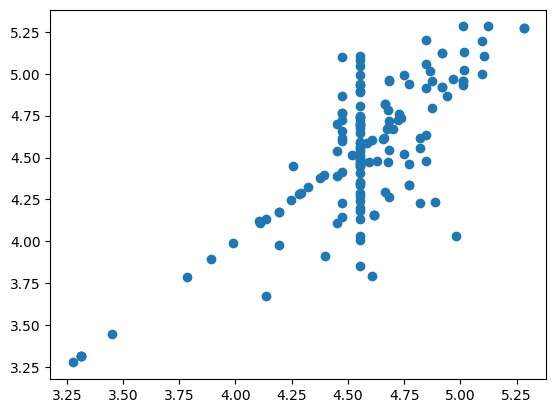

In [89]:
print(x_test_all.columns)
x_test_mod = x_test_all
x_test_mod.drop(columns=['2.0', '3.0', '4.0', '5.0', 'Size_1 to 50 employees', 'Size_10000+ employees',
       'Size_1001 to 5000 employees', 'Size_201 to 500 employees',
       'Size_5001 to 10000 employees', 'Size_501 to 1000 employees',
       'Size_51 to 200 employees', 'Size_Unknown'])

x_train_mod = x_train_all
x_train_mod.drop(columns=['2.0', '3.0', '4.0', '5.0', 'Size_1 to 50 employees', 'Size_10000+ employees',
       'Size_1001 to 5000 employees', 'Size_201 to 500 employees',
       'Size_5001 to 10000 employees', 'Size_501 to 1000 employees',
       'Size_51 to 200 employees', 'Size_Unknown'])

cart = tree.DecisionTreeRegressor(max_depth=20) # Create a classifier object
cart = cart.fit(x_train_mod, y_train) # Fit the classifier

r2 = cart.score(x_test_mod, y_test)
y_hat = cart.predict(x_test_mod)
residuals = y_test - y_hat
SSE = np.sum(np.square(y_hat - y_test))
RMSE = (SSE/N_test)**(1/2)
print("Sector and Rating - R2 and RMSE for depth of 20")
print(r2, '\n')
print(RMSE, '\n')

plt.scatter(y_hat, y_test)

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?